# FEniCSx Analytical VS Computed Solutions

In this tutorial, we will be continuing our FEniCSx Bridge example from part 1, except this time we will be fully incoprorating the 3rd dimension and make our bridge a 3D structure. Last time, our bridge had a force applied to it at a single point at the center of the beam but in the Y direction. This time, we added depth and will be applying a downward force in the Z-axis. In this tutorial, we will see the accuracy of FEniCSx when comparing our answers to an analytical soltuion. Before getting into the problem, please ensure that FEniCSx and DolfinX are installed on your computer. For assistance with installation, please refer to the `readme.md` for tips on installing the platform, creating a conda environment, activating it (also in your terminal/visual studio session), and running the Jupyter Notebook.

## Library Imports

To ensure that FEniCSx runs properly, please run each Jupyter notebook cell in order. If you run any cells ahead of others, the code might error out. First and foremost, we call our imports, the main ones being Numpy, DolfinX, UFL. 

Here:

- Numpy:        Standard import which is for computations and arrays
- DolfinX:      Core FEniCSx library for FEA
- UFL:          Domain-specific language usedfor FEA


In [1]:
from dolfinx import mesh, fem, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from dolfinx import geometry
from mpi4py import MPI
import dolfinx.fem.petsc
import matplotlib.pyplot as plt
import numpy as np
import ufl

## Simple Bridge Problem Setup

Next we need to initialize our problem variables. As discussed before, we are setting up a 3 dimensional bridge, fixed on both ends, and simulating a downward force right along the beam. Differing from part 1, we are no longer applying a force as a point right in the middle of the bridge, instead we are applying a uniform load across the whole bridge.

The steps for this problem will look like this:
1) Define mesh
2) Create the domain space (label the edges)
3) Define material properties

In [2]:
# Bridge dimensions
L, W, H = 10.0, 1.0, 0.5  # Length, width, height
num_elements = [25, 5, 5]  # Mesh resolution 

# Create a 3D bridge mesh
domain = mesh.create_box(MPI.COMM_WORLD, [[0.0, 0.0, 0.0], [L, W, H]], num_elements, mesh.CellType.hexahedron)
V = fem.functionspace(domain, ("Lagrange", 2, (domain.geometry.dim, )))
dim = domain.topology.dim

# Material properties for bridge
rho = 800  # Density 
E = fem.Constant(domain, 2.1e11)  
nu = fem.Constant(domain, 0.3)
mu = (E / (2 * (1 + nu)))
lmbda = (E * nu / ((1 + nu) * (1 - 2 * nu)))


## Defining Functions

In this section we define our trial and test functions to pass to FEniCSx. For ease of work, we explicitly define an epsilon and a sigma function. This will also help in bug testing and troubleshooting in case of issues in the future (This was actually very handy).

In [3]:
# Define the weak form
u = ufl.TrialFunction(V)  # Displacement as a vector field
v = ufl.TestFunction(V)  # Test function
solution = fem.Function(V)  # Solution vector

def epsilon(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return lmbda * ufl.tr(epsilon(v)) * ufl.Identity(dim) + 2 * mu * epsilon(v)

## Boundary Conditions

Simple boundary condition application, defining left and right boundaries of the beam. Left boundary conditions are at 0,0. Right boundary conditions are the length of the beam.

In [4]:
# Boundary conditions: Fix both ends of the bridge
def left_end(x):
    return np.isclose(x[0], 0.0)

def right_end(x):
    return np.isclose(x[0], L)


left_dofs = fem.locate_dofs_geometrical(V, left_end)
right_dofs = fem.locate_dofs_geometrical(V, right_end)
zero_displacement = np.array([0.0, 0.0, 0.0], dtype=default_scalar_type)
bcs = [fem.dirichletbc(zero_displacement, left_dofs, V),
       fem.dirichletbc(zero_displacement, right_dofs, V)]

## Force Application

Next we define our exernal load for our beam, using a uniform constant downward Z force. We then create our weak form equation that we will pass to the solver.

In [5]:
# External force: Vertical force applied uniformly
q = fem.Constant(domain, default_scalar_type((0.0, 0.0, -1e4)))  # Force in the negative z-direction
dx = ufl.Measure("dx", domain=domain)
a = ufl.inner(sigma(u), epsilon(v)) * dx
L_form = ufl.inner(q, v) * dx

## Solver Initialization

We now initialize our solver using a linear solver. This approach is valid for linear problems or problems that can be approximated as linear. We could always use a nonlinear solver and the newton solver for this, however we would need to change our problem formulation entirely from the beginning. We are also monitoring the iterations for troubleshooting. 

In [6]:
# Solver setup using a linear solver
problem = LinearProblem(a, L_form, bcs=bcs, u=solution)

def Monitor(ksp, iterations, residual_norm):
    print(f"Iteration {iterations}, residual {residual_norm}")

problem.solver.setMonitor(Monitor)
problem.solver.setTolerances(rtol=1e-9, atol=1e-9)

problem.solve()

Iteration 0, residual 2.1982622327425553e-08
Iteration 1, residual 1.4132391762372027e-08
Iteration 2, residual 1.3431683457677378e-08
Iteration 3, residual 1.3359110572582785e-08
Iteration 4, residual 1.3333316698328803e-08
Iteration 5, residual 1.3152748870735124e-08
Iteration 6, residual 1.2937379330331044e-08
Iteration 7, residual 1.2914223656662157e-08
Iteration 8, residual 1.2907318256681158e-08
Iteration 9, residual 1.2795024857869611e-08
Iteration 10, residual 1.2519275300944486e-08
Iteration 11, residual 1.2519012466858173e-08
Iteration 12, residual 1.2482713978013423e-08
Iteration 13, residual 1.2477803623440544e-08
Iteration 14, residual 1.2247903894055376e-08
Iteration 15, residual 1.2114519393031915e-08
Iteration 16, residual 1.2114426126678522e-08
Iteration 17, residual 1.2100777752340363e-08
Iteration 18, residual 1.2021619008028532e-08
Iteration 19, residual 1.2007139513291392e-08
Iteration 20, residual 1.1998990677398336e-08
Iteration 21, residual 1.1993876166549375e-0

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, hexahedron, 1, gll_warped, unset, False, float64, []), (3,)), 0), blocked element (Basix element (P, hexahedron, 2, gll_warped, unset, False, float64, []), (3,))), 0)

## Visualization

For visualization, we tackle this by two fronts. The first, we use the FEniCSx bounding box class. We find the cells containing our desired points so we can see the displacement in the middle of the beam. We use a generic amount of 100 points on the beam and take all points that are around the middle of the beam in terms of vertical, horizontal, and width-wise. We take those points and then compare their displacement for the analytical solution and computed solution. We plot this with pyplot and compare the error between the two. 

Error: 0.0005407414924076377


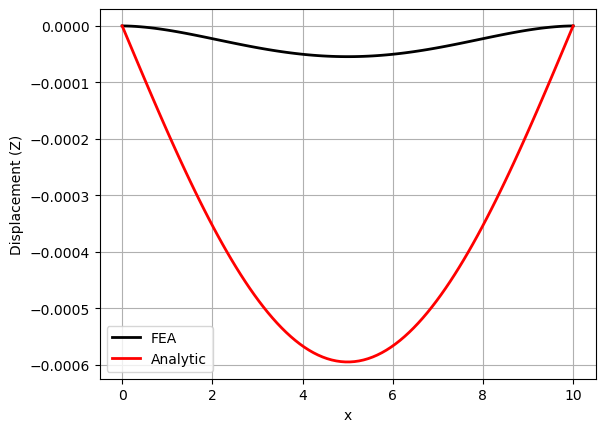

In [7]:
# moment of inertia for cross-section
Inertia = W * H**3 / 12 

# bounding box tree for collision detection
bb_tree = geometry.bb_tree(domain, domain.topology.dim)

# Points along the beam's length for displacement evaluation 
x = np.linspace(0, L, 100) 
points = np.zeros((3, 100)) 
points[0] = x
points[1] = W / 2  # Mid-width 
points[2] = H / 2  # Mid-height 

cells = []
points_on_proc = []
u_values = []

# Find cells containing the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = solution.eval(points_on_proc, cells)

# Plot FEA results
fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values[:, 2], "k", linewidth=2, label="FEA")  # Z-displacement
plt.grid(True)

# Define the analytic solution for comparison
u_analytic = lambda x: (q.value[2] / (24 * E.value * Inertia)) * (x**4 - 2 * L * x**3 + L**3 * x)
x_analytic = np.linspace(0, L, 100)
u_analytic_values = u_analytic(x_analytic)

# Compute and save the error
error = np.max(np.abs(u_values[:, 2] - u_analytic_values))
print(f"Error: {error}")

# Plot analytic solution
plt.plot(x_analytic, u_analytic_values, "r", linewidth=2, label="Analytic")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("Displacement (Z)")
plt.legend()
output_png = "Computed_vs_Analytic_Error.png"
plt.savefig(output_png)

## Results

We have a saved `Computed_vs_analytic_error.png` file saved in our directory. This shows us the error between the computed solution and the analytical one. While the plot itself may look inaccurate, the real error is actually 5x10^-4, which is very acceptable!